# Outline

First, we'll be pytorchifying our code even more; we're basically building up the core parts of torch.nn from scratch lol. From tanh, to linear, to batchnorm, to embedding and flatten, and then the sequential class, etc... Cool!

Then, we'll get to the cooooool RNNs and stuff!

In [45]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [46]:
# read in all the words
words = open('../2 - makemore/names.txt', 'r').read().splitlines()
words[:8]
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
len(words)

32033

In [47]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [48]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [49]:
for x, y in zip(Xtr[:20], Ytr[:20]):
	# print(x,y)
	print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])
## Mmm tasty x -> y examples (we got 182625 training examples hehe)

... ---> y
..y ---> u
.yu ---> h
yuh ---> e
uhe ---> n
hen ---> g
eng ---> .
... ---> d
..d ---> i
.di ---> o
dio ---> n
ion ---> d
ond ---> r
ndr ---> e
dre ---> .
... ---> x
..x ---> a
.xa ---> v
xav ---> i
avi ---> e


In [120]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass.
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []


In [51]:
torch.manual_seed(42); # seed rng for reproducibility

In [52]:
# original network
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd)) # generate the embedding matrix

layers = [
	Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	Linear(n_hidden, vocab_size),
]

# parameter init
with torch.no_grad():
	layers[-1].weight *= 0.1 # last layer make less confident for better softmax initialised. (makes initial closer to equal prob distr output)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
	p.requires_grad = True

12097


In [53]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into the vectors || (batch_size, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat each char vector for some i'th training example together, from a [3,10] into a [30]. || I.e Concat into (batch_size (32), block_size * n_embed)
  ## OOOh, basically, the '-1' means "figure out what this is, but my other dimension MUST BE THIS (emb.shape[0]) in this case". So pog. And since we made it a 2d, yeah. It changed it to a 2D with [emb.shape[0], inferred value]
  
  for layer in layers:
    x = layer(x)

  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/  20000: 3.2966
  10000/  20000: 2.2322


In [54]:
emb.view(emb.shape[0], -1).shape, emb.shape


(torch.Size([32, 30]), torch.Size([32, 3, 10]))

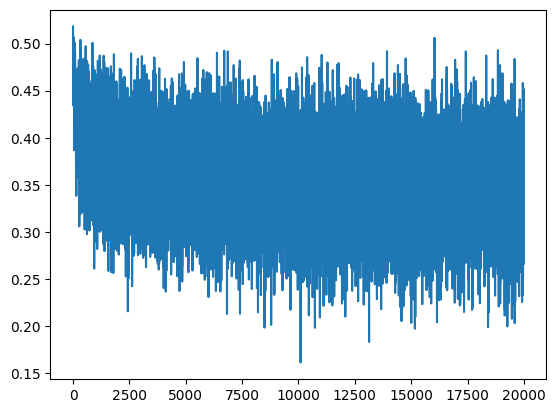

In [55]:
plt.plot(lossi)

In [56]:
# put layers into eval mode (for batchnorm)
for layer in layers:
	layer.training = False

In [57]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # Concat into (N, block_size * n_embed)
  
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.214060068130493
val 2.23262357711792


In [58]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all '...'
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (N, block_size, n_embd) || get the embedding of our current tri-example like '...'. 
      x = emb.view(emb.shape[0], -1) # Concat into (N, block_size * n_embed)
  
      for layer in layers:
        x = layer(x)
      probs = F.softmax(x, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

ageor.
kymanarura.
nola.
khadricton.
nykh.
makalizey.
kash.
jeney.
zaulia.
hadio.
emh.
terather.
bhanth.
avike.
tin.
leamora.
naise.
nekyae.
lal.
faitliyones.


# ----------------------------------------------
Okay, now onto video.

First, let's fix our awful loss plot lmao.

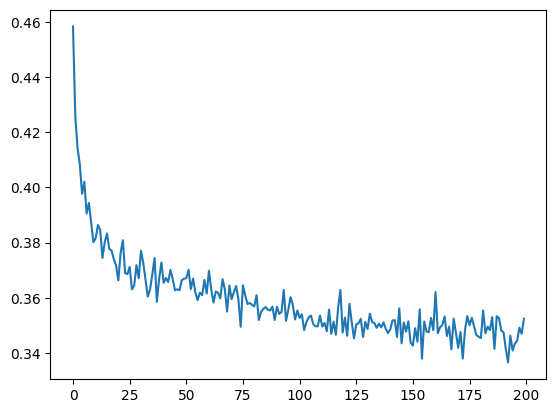

In [59]:
torch.arange(27).view(3,3,3) # Tada! Magic.
plt.plot(torch.tensor(lossi).view(-1, 100).mean(1)) # Convert lossi into a 2d matrix, 100 columns, and then mean up column wise
# If you do the full 200k training steps, and use 1000 columns, you'll see it slow down like usual and then get a spike down, corresponding to our learning rate change

Cool!
Now, let's go pytorchify/modularise our code a bit more. We see that we're looking into the C embedding matrix and then changing the view of it in the forward pass, instead of just having it act like a layer or something. Let's change that.


In [89]:
class Embedding:
	def __init__(self, num_embeddings, embedding_dim) -> None:
		""" Embedding class for generating one in the forward pass

		Args:
			num_embeddings: number of embeddings you want to have (like vocab size -- the alphabet -- how many items do you want in a vector representation)
			embedding_dim: size of each embedding
		"""
		
		self.weight = torch.randn((num_embeddings, embedding_dim))

	def __call__(self, IX):
		"""_summary_

		Args:
			IX (_type_): Index of the embedding you want (e.g index 26 would be z, index 0 is '.')

		Returns:
			_type_: _description_
		"""
		self.out = self.weight[IX]
		# print("Hey, I'm in embedding!:", self.out.shape)
		return self.out

	def parameters(self):
		return [self.weight]

class Flatten:
	"""
	The flattening operation of the embeddings so we can throw it through our NN
	and it can actually read it, instead of some wack 3D shape.
	"""

	def __call__(self, x: torch.Tensor):
		self.out = x.view(x.shape[0], -1) # Force the x tensor into a 2D matrix, that must satisfy the 0th dim (# rows) being x.shape[0]. Basically, flattens 1st, 2nd dim into dim 1.
		return self.out

	def parameters(self):
		return []

In [61]:
torch.manual_seed(42)

In [62]:
# So now let's set up the new training loop with these in store!
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP


layers = [
	Embedding(vocab_size, n_embd), 
	Flatten(),
	Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	Linear(n_hidden, vocab_size),
]

# parameter init
with torch.no_grad():
	layers[-1].weight *= 0.1 # last layer make less confident for better softmax initialised. (makes initial closer to equal prob distr output)

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
	p.requires_grad = True

12097


In [63]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  x = Xb # since we moved Embedding stuff to layers list, we want the first 
  # x to be the indexes that we'll be looking up in the embedding first. yay!
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

Hey, I'm in embedding!: torch.Size([32, 3, 10])
      0/  20000: 3.2966


Alright, instead of having a funky layers list, pytorch has a torch.nn.Sequential, where you basically store all the layers in a sequential order. Let's build that (at least the most important parts of it)

In [64]:
class Sequential:

	def __init__(self, layers) -> None:
		self.layers = layers

	def __call__(self, x):
		# Given an input, call all the layers sequentially, then return that final output.
		for layer in self.layers:
			x = layer(x)
		self.out = x
		return self.out
	def parameters(self):
		# Return number of parameters of everything in this sequential class
		return [p for layer in self.layers for p in layer.parameters()]

In [65]:
# So now let's set up the new training loop with these in store!
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP


model =  Sequential([
	Embedding(vocab_size, n_embd), 
	Flatten(),
	Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident
  
parameters = model.parameters() # boom!
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
	p.requires_grad = True

12097


In [153]:
# same optimization as last time

def train_sequential_model(model):
	max_steps = 20000
	batch_size = 32
	lossi = []
	for i in range(max_steps):
		# minibatch construct
		ix = torch.randint(0, Xtr.shape[0], (batch_size,))
		Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

		# forward pass
		logits = model(Xb) # Boom! Just call the model, inputting Xb, and viola! Your logits (by definition, the output of your NN after its layer processing) are here :D
		loss = F.cross_entropy(logits, Yb) # loss function
		
		# backward pass
		for p in parameters:
			p.grad = None
		loss.backward()
		
		# update: simple SGD
		lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
		for p in parameters:
			# print(p.grad)
			p.data += -lr * p.grad

		# track stats
		if i % 1000 == 0: # print every once in a while
			print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
		lossi.append(loss.log10().item())

In [ ]:
train_sequential_model(model)

In [67]:
# COoool. Now let's set it into eval mode so we can do stuff again.

In [68]:
# put layers into eval mode (for batchnorm)
for layer in model.layers:
	layer.training = False

In [69]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


Hey, I'm in embedding!: torch.Size([182625, 3, 10])
train 3.2867496013641357
Hey, I'm in embedding!: torch.Size([22655, 3, 10])
val 3.2875399589538574


In [70]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all '...'
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word
# Btw, if you didn't run the "set self.training to false" above, this code would still work but it's using the wrong variables -- like the batchnorm would be doin le stuff on the wrong vars (over whole training set inputted) instead of the running vars. 
# And you could definitely tell if it's fucked in the sampling, because it would give an error: you can't get the variance of a single sample! (srs, it gives 'nan'. Also, it doesn't make sense to find spread of 1 sample) 

Hey, I'm in embedding!: torch.Size([1, 3, 10])
Hey, I'm in embedding!: torch.Size([1, 3, 10])
Hey, I'm in embedding!: torch.Size([1, 3, 10])
Hey, I'm in embedding!: torch.Size([1, 3, 10])
Hey, I'm in embedding!: torch.Size([1, 3, 10])
gjoi.
Hey, I'm in embedding!: torch.Size([1, 3, 10])
Hey, I'm in embedding!: torch.Size([1, 3, 10])
Hey, I'm in embedding!: torch.Size([1, 3, 10])
Hey, I'm in embedding!: torch.Size([1, 3, 10])
Hey, I'm in embedding!: torch.Size([1, 3, 10])
Hey, I'm in embedding!: torch.Size([1, 3, 10])
Hey, I'm in embedding!: torch.Size([1, 3, 10])
Hey, I'm in embedding!: torch.Size([1, 3, 10])
Hey, I'm in embedding!: torch.Size([1, 3, 10])
Hey, I'm in embedding!: torch.Size([1, 3, 10])
Hey, I'm in embedding!: torch.Size([1, 3, 10])
Hey, I'm in embedding!: torch.Size([1, 3, 10])
Hey, I'm in embedding!: torch.Size([1, 3, 10])
Hey, I'm in embedding!: torch.Size([1, 3, 10])
Hey, I'm in embedding!: torch.Size([1, 3, 10])
tfqcwowpsbivyh.
Hey, I'm in embedding!: torch.Size([1,

In [71]:
torch.tensor(context).shape, torch.tensor([context]).shape # That's why you wanna wrape context in another list -- to make it 2d.

(torch.Size([3]), torch.Size([1, 3]))

# WaveNet time!

The general idea of this is to slowly diffuse the character information into the system, instead of getting the entire context and just CRUSHING IT straight up into a single layer with the embed. Like, we're losing stuff because how fast we're crushing it.

The way this works is: basically we get 2 characters, it makes a bigram, get two bigrams, makes a four gram, .... 
This is so that we basically crush the information slowly, as the info gets deeper and deeper into the NN. And the bet is that we can learn better from it.
https://www.youtube.com/watch?v=t3YJ5hKiMQ0 18:00

Since we're gonna be changing stuff, let's get a performance log. Like, look here for block size = 8: (when we're crushing 8 things at once :skull:)
### Performance log
original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105

context: 3 -> 8 (22K params): train 1.918, val 2.027)

flat -> hierarchical (22K params): train 1.941, val 2.029

fix bug in batchnorm: train 1.912, val 2.022

scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993




In [72]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


## Beginning to explore slower embedding/flatten speeds to conserve information
We're gonna implement stuff!!! Like first only concating each 2 consecutive embeds, and then pushing that through layers in parallel.

In [73]:
# print first 10 examples in the training sets
for x, y in zip(Xtr[:10], Ytr[:10]):
	# print(x,y)
	print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])
## Mmm tasty x -> y examples (we got 182625 training examples hehe)

........ ---> e
.......e ---> b
......eb ---> r
.....ebr ---> i
....ebri ---> m
...ebrim ---> a
..ebrima ---> .
........ ---> h
.......h ---> i
......hi ---> l


### Scratch space for experimenting with batching pairs of characters

In [74]:
## Just setting up a 'scratch space' rough place where we can see what's happening in the model easily
ix = torch.randint(0, Xtr.shape[0], (4,)) # batch of just 4 examples
print(f'{ix=}')
Xb, Yb = Xtr[ix], Ytr[ix]

logits = model(Xb)
print(f'{Xb.shape=}, {block_size=}')
print(Xb) # 4 examples, each 8 characters.

ix=tensor([ 48048, 179099, 152617,  69614])
Hey, I'm in embedding!: torch.Size([4, 8, 10])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x80 and 30x200)

In [ ]:
for layer in model.layers:
	print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [ ]:
model.layers[0].out.shape # Output of embedding layer || Every char (for our block size of 8) is translated into a 10 dimensional vector

AttributeError: 'Embedding' object has no attribute 'out'

In [ ]:
model.layers[1].out.shape # Output of Flatten layer. Did exactly what it does lol.

torch.Size([4, 80])

In [ ]:
model.layers[2].out.shape # Output of Linear Layer, i.e multiply the flattened 8 block size embed * weight matrix.


torch.Size([4, 200])

Behold... Pytorch matrix multiplication, and how we can do poggers stuff with it:

In [ ]:
print((torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape)
# But look!
print((torch.randn(4,6,4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape)
##  Basically, pytorch just ignores all the dimensions to the left (they're unchanged) and it only does matrix multiplication on the *last* dimension.
# So we can do batches on batches, yo!

torch.Size([4, 200])
torch.Size([4, 6, 4, 200])


In [ ]:
# 1 2 3 4 5 6 7 8 || So our block size 8 means 8 chars per training example
"""
Before, we would embed and then concat all of them together to make that
(1,80). But we don't want it to flatten everything at once and multiply it all there -- the process of squishing the information is too quick.

> Instead, we want to group the concats like this!

(1 2) (3 4) (5 6) (7 8)

So every 2 consecutive elements should be flattened out and then multiplied by a weight matrix.

But we want each of these 4 groups to be processed in parallel.
It's like a *batch dimension*.

/// So back to the torch stuff.

We basically don't want the (4,80) flattened going into the weight matrix straight away.
Instead of our 8 chars at once, we'd want 2 characters going in, then getting flattened ('fused').

I.e, our flattened thing would be 20 long. So we don't want an 80 flattened, we want a 20 flattened.
So our weight matrix would be (20, 200).

Cool!
And since we don't want 80 to feed in anymore, we want the groups of 2 to feed in (each having 10 embed dim), i.e we'd want 20 to feed in. And since we have 4 batches of those 20s, well....
We'd want to have a (4, 4, 20) flattened matrix thingy.
>> This is: For each training example (4 examples in this case), we got the 4 groups (depending on our block size) of 2 characters (which are converted via embedding to each have 10 dimensional vector).

"""

In [ ]:
print((torch.randn(4,4,20) @ torch.randn(20, 200) + torch.randn(200)).shape)
# So you see, how the flattened embed (i.e each group of (1,2) (3,4) ...) are multipled through the weight matrix at the same time, but still remain separate in their own batches. Yay!!!

"""
> First dim: First batch dimension; number of examples (of some N context size abcdefgh (well, they're actually numbers but fuck you too))
> Second dim: Second batch dimension: Refers to the 4 groups of pairs (a b) (c d) (e f) (g h) ... 
> Third dim: Ofc the embedded flattened version of the 2 chars (output of flatten layer). And this is multiplied with the weight.

So let's get to changing the classes!
"""


torch.Size([4, 4, 200])


In [ ]:
e = torch.randn(4, 8, 10) # from embed layer: goal is to make this (4, 4, 20) where consecutive 10d vectors are concatenated
# Heyo! Python list indexing pog

In [ ]:
print(list(range(10))[::2], list(range(10))[1::2])
# Hmmm. So we want to add 0+1's vectors, then 2+3's vectors...
print(e[:, ::2, :].shape, e[:, 1::2, :].shape) # Okay. 
# So we're basically indexing into the even/odd chars with this hehe. Now, what if we just add them?

[0, 2, 4, 6, 8] [1, 3, 5, 7, 9]
torch.Size([4, 4, 10]) torch.Size([4, 4, 10])


In [ ]:
#let's concat them along the 2nd dimension!
explicit = torch.concat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [ ]:
# Guess what mfer. View just so happens to do what we want lmao!

(e.view(4,4,20) == explicit).all() # checks if all elements in tensor are true

tensor(True)

In [1]:
# Let's update our flatten class!
class FlattenConsecutive: # Because we start departing from the pytorch API classes here
	# We'd be making something like (4,8,10) into (4,4,20). Concatenate the last dimensions together through the second batch. 
	# Remember, the whole point of this class is so we don't just Flatten the entire block size embeds at once, but slowly do it over time. 
	def __init__(self, n):
		# n is number of elements that are consecutive, that we want to concat into the last dimension of our output
		self.n = n 

	def __call__(self, x: torch.Tensor):
		B, T, C = x.shape  # this is from the embedding matrix basically -- so C is actually the embedding length (e.g 10 dim). B is the batch size (# of training examples inputted), and T is the context length or block size. (I.e, are we using 3 or 8 characters (etc.) to predict the next one).
		# Ex: A (4,8,10) means that you have 4 examples, each example having a context length (block size) of 8 -- i.e you are using 8 characters to predict, and each character has been 10 dimensional embedded.
		
		x = x.view(B, T//self.n, C*self.n) # could use -1 for 2nd dim, but karpathy likes being expicit in what to expect so you know where errors are coming from || E.g if T=blocksize=8, and n=2, 8//2 = 4. Pog. And C*2=10*2 = 20. We're just concating each 2 consecutive char embeddings together, and view does it in the way we want.

		if x.shape[1] == 1: # if 2nd dim is 1, then just return the 2D matrix instead and take out the 1 dim length || E.g it would go (4,8,10) -> (4,4,20) -> (4,2,40) -> (4,1,80) so we just take out the 1 because it's like '1' superchar. Look below for how we use the flattenconsecutives. See how we diffused the flattening over layers instead of doing it all at the beginning like with the flatten class way above?
			x = x.squeeze(1)  
		self.out = x  
		return self.out

	def parameters(self):
		return []

NameError: name 'torch' is not defined

So now let's try it out~!


In [121]:
# New model initialisation with flattenconsecutive. I.e don't squish the 8 context into one layer ASAP, but diffuse it into it with pairs, then pairs of those pairs, then pairs of those pairs of those pairs (2^3).
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP
# 68 to roughly match the # params in our other model, so we can better gauge the effectiveness of the different architectures
model =  Sequential([
	Embedding(vocab_size, n_embd), 
	FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # nembed * 2 linear layer because it's only receiving a size 20 embed thingy now, instead of our old size 80 (nemb*block_size).
	FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	Linear(n_hidden, vocab_size)
])

# parameter init
# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

  
parameters = model.parameters() # boom!
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
	p.requires_grad = True

22397


In [122]:
## Just setting up a 'scratch space' rough place where we can see what's happening in the model easily
ix = torch.randint(0, Xtr.shape[0], (4,)) # batch of just 4 examples
print(f'{ix=}')
Xb, Yb = Xtr[ix], Ytr[ix]

logits = model(Xb)
print(f'{Xb.shape=}, {block_size=}')
print(Xb) # 4 examples, each 8 characters.


ix=tensor([163687, 173446, 166496,  29384])
Xb.shape=torch.Size([4, 8]), block_size=8
tensor([[ 0,  0,  0,  0,  0,  0,  0, 19],
        [ 0,  0,  0,  0,  0,  0,  9, 19],
        [ 0, 13,  1, 11, 25, 14, 12,  5],
        [ 0,  0, 20,  9,  1, 18, 18,  1]])


In [123]:
def get_model_structure(model):
	for layer in model.layers:
		print(layer.__class__.__name__, ':', tuple(layer.out.shape))
# see how first we flatten into (4,4,20), then ..., then we bring that new shit and then flatten it consecutively again into a 2, 400 (i.e these would be a 4 large context), and then blah, resets to 200 via the linear layer eating it, 

# Sometimes it runs properly, sometimes gives an error saying embed has no out. No fuckin idea why
get_model_structure(model)
print(n_hidden * 2, 2 *n_embd)


Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)
136 20


In [124]:
# Train model if you want 
train_sequential_model(model)
get_model_structure(model) # 32 because they get minibatched


      0/  20000: 3.3010
Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [125]:
# put layers into eval mode (for batchnorm)
for layer in layers:
	layer.training = False

# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.278094530105591
val 3.277949333190918


Basically, we implemented this but for 8 instead of 16.
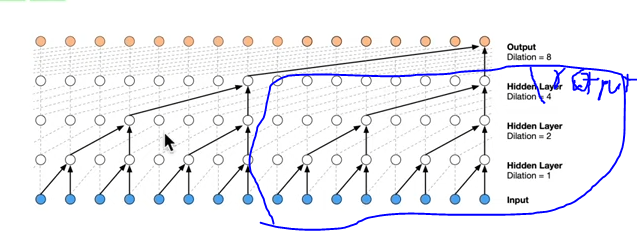

Okay, so we updated performance log -- karpathy ran the training code with the new model, I cba.

flat -> hierarchical (22K params): train 1.941, val 2.029. So about the same as 3-8 context, but there's actually a bug in batchnorm now, even though the code still runs!! Aha!!

## Fix bug in batchnorm1d

So here's the issue, with a toy example

In [126]:
e = torch.randn(32, 4, 68) # received input into  batchnorm
emean = e.mean(0, keepdim=True) # 1,4,68
evar = e.var(0, keepdim=True) # 1,4,68
ehat = (e - emean) / torch.sqrt(evar + 1e-5) # 32, 4, 68
ehat.shape # bru


torch.Size([32, 4, 68])

In [129]:
model.layers[3].running_mean.shape # So, this is odd, because running mean  should just be (1,68). 


torch.Size([1, 4, 68])

In [137]:
# Can fix it with 
e = torch.randn(32, 4, 68) # received input into  batchnorm
emean = e.mean((0,1), keepdim=True) # 1,1,68
evar = e.var((0,1), keepdim=True) # 1,1,68
ehat = (e - emean) / torch.sqrt(evar + 1e-5) # 32, 1, 68
emean.shape # Nice. 

torch.Size([1, 1, 68])

In [143]:
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training: # checks 2d/3d. Bit different from pytorch implementation: We assume the last dim is what we want, it assumes first dim (dim 1) is what we want.
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]


In [144]:
# New model initialisation with flattenconsecutive. I.e don't squish the 8 context into one layer ASAP, but diffuse it into it with pairs, then pairs of those pairs, then pairs of those pairs of those pairs (2^3).
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP
# 68 to roughly match the # params in our other model, so we can better gauge the effectiveness of the different architectures
model =  Sequential([
	Embedding(vocab_size, n_embd), 
	FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	Linear(n_hidden, vocab_size)
])

# parameter init
# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

  
parameters = model.parameters() # boom!
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
	p.requires_grad = True

22397


In [145]:
# Cool, so let's retrain
train_sequential_model(model) # imagine this didn't break at first step; let's take karpathy's val/loss
print(model.layers[3].running_mean.shape) # Cool! Running mean is fixed! 
split_loss('train')
split_loss('val')

## Performance log updated!!, fix bug in batchnorm: train 1.912, val 2.022

      0/  20000: 3.2982
torch.Size([1, 1, 68])
train 3.280322551727295
val 3.280872106552124


Now let's scale up our WaveNet!!!

In [150]:
torch.manual_seed(42);

In [151]:
## Boooom! Yeah, we basically just increased our embed size to 24 haha
n_embd = 24 
n_hidden = 128 
model =  Sequential([
	Embedding(vocab_size, n_embd), 
	FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	Linear(n_hidden, vocab_size)
])

# parameter init
# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident
  
parameters = model.parameters() # boom!
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
	p.requires_grad = True

76579


In [154]:
train_sequential_model(model) # imagine this didn't break at first step; let's take karpathy's val/loss
split_loss('train')
split_loss('val')

## Anyways, so karpathy's vals are taken here:
# scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993

## Note, that if you were to actually take off the break in train and really train it, it takes a lot longer to train compared to the other models!! Just because there's so many more parameters, yeah. Sheeesh

      0/  20000: 3.2481
   1000/  20000: 2.1492
   2000/  20000: 1.8624
   3000/  20000: 2.1689
   4000/  20000: 2.1611
   5000/  20000: 2.2298
   6000/  20000: 2.0086
   7000/  20000: 2.5093
   8000/  20000: 2.3162
   9000/  20000: 1.9915
  10000/  20000: 1.9011
  11000/  20000: 2.0888
  12000/  20000: 2.6927
  13000/  20000: 2.3011
  14000/  20000: 2.4395
  15000/  20000: 2.1827
  16000/  20000: 2.2994
  17000/  20000: 2.1462
  18000/  20000: 1.9062
  19000/  20000: 1.9464
torch.Size([1, 1, 128])
train 2.0421669483184814
val 2.091167688369751
